<a href="https://colab.research.google.com/github/isdeniz/results-2406/blob/main/model_msc_bug_enhc_oos_preprocessing_msc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install transformers==4.40.2

In [2]:
pip install simpletransformers==0.64.3

In [3]:
import transformers
>>> transformers.__version__

'4.40.2'

In [4]:
import pandas as pd
from functools import partial
import sklearn
import torch
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import logging
import datetime
from sklearn.metrics import confusion_matrix # additional line
import seaborn as sns # additional line
import matplotlib.pyplot as plt # additional line
import torch.multiprocessing # additional line
import os # additional line
os.environ["TOKENIZERS_PARALLELISM"] = "false" # additional line
torch.multiprocessing.set_start_method('spawn', force = True) # additional line
pd.set_option('display.max_colwidth', None)
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)
torch.multiprocessing.set_sharing_strategy('file_system')
cuda_available = torch.cuda.is_available()
print("Is cuda available?", cuda_available)

Is cuda available? True


load and prepare data

In [5]:
train = pd.read_csv('data/train_bug_ench_oos_msc_preprocessing.csv')
test = pd.read_csv('data/test_bug_ench_oos_msc_preprocessing.csv')
print('Number of issues: ', train.shape, test.shape)

Number of issues:  (171392, 2) (19044, 2)


In [6]:
train.head()

,text,labels
0,2019-11-11T20:22:40Z CONTRIBUTOR Anuken/Mindustry proper ime input method editor support B platform android ios mac windows linux windows 10 build the build number under the title in the main menu. required. 99.6 issue explain your issue in detail. when trying to chat in chinese the input method bar is missing. the bar is usually looks like however it's not shown in the chat and other places. image https user images.githubusercontent.com 822628 68618154 98d8f580 047d 11ea 9b3f 29f179506636.png i think it's a common issue for function ime and it's might be an issue of the engine https github.com anuken arc blob master arc core src io anuke arc scene ui textfield.java not the game itself. steps to reproduce how you happened across the issue and what you were doing at the time. enable any input method on windows 10 try type in text inputs in the game.,3
1,2020-03-05T18:43:40Z CONTRIBUTOR Anuken/Mindustry need help finding where ui.picker.show comes from B in lightblock.java https github.com anuken mindustry blob master core src mindustry world blocks power lightblock.java there is ui.picker.show what file does this come from? asking so i can figure out how to make a custom dialogue that is similar with scripting,3
2,2020-03-15T17:44:05Z CONTRIBUTOR Anuken/Mindustry community vote for translations B some translations are false so you should add a vote to approve or disapprove the changes in the concerned community for exemple if there is a new translation to russian russian people will vote and if the majority agree with the changes bundle will be updated but else it won't,3
3,2017-12-14T03:51:41Z OWNER Anuken/Mindustry localization checklist B this will be a separate checklist for setting up localization. libgdx i18bundle documentation link https github.com libgdx libgdx wiki internationalization and localization x add i18bundle variable to control vars class set up appropriate way to fetch text easily x set up assets directory for text files x create basic test bundle and get 'fetching' working x make i18bundle work with all ui x make i18bundle work with all block descriptions and extended descriptions x make i18bundle work with map names ? x remove short descriptions if possible and replace them with something else x transcribe all ingame text to i18bundle strings x translate to french contact omicron translation team x translate to russian already found a translator who is willing or i can even do it myself x translate to german,3
4,2020-04-27T09:54:42Z CONTRIBUTOR Anuken/Mindustry new jdk version support B despite feature request issue template saying to post suggestions in the other repo i decided to post this here. the point mindustry doesn't support jdk 8 causing developers who use newer jdk install jdk 8 to compile the game. it will be nice to make mindustry support jdk 8. the purpose many java developers use newer jdk's i.e. 11 so they must load and install jdk 8 to build the game although they are not really want to. sometimes you couldn't build the game even with the jdk 8 installed as mentioned in issue . also 8th java version is slowly going out of support so the game could lose some contributors using newer jdk's. some linux distros doesn't even have java 8 or lower in their repos. so fixing the incompability will allow to build the project with jdk 11 but no backwards compability will be lost you will be able to build the project with jdk 8 . the solution after doing some research i found out that the main cause of incompability with newer jdk's is gradle the game uses version 5.6.4 byt the time the last version is 6.3 . if you upgrade the gradle wrapper the main problem will be gone. also there are some minor problems in annotations' module some code in annotationproxymaker use sun api which is incompatible with modern jdk's . if you are too busy to fix such minor problem you could assign the issue to me and i will make a pr fixing the problem.,3


In [7]:
test.head()

,text,labels
0,2019-03-05T09:30:17Z NONE OpenAPITools/openapi-generator swift4 update alamofire dependency B the current alamofire dependency for swift is 4.7.0 and the current stable version is 4.8.1 with 5.0 in beta . the major issue with the current dependency is the use of deprecated synax in the request extension located in responseserilization.swift along with use of 'let' properties that are implicitly 'final' and should use 'public' instead of 'open' in a multitude of components causing compiler warnings see attached screenshot . suggested fix the alamofire dependency should be updated to the latest stable version optionally monitoring updates to avoid similar problems in the future. screenshot 2019 03 05 at 10 19 08 https user images.githubusercontent.com 10880165 53794493 665f1c00 3f30 11e9 88e0 a816b33623d5.png,1
1,2020-11-02T15:27:17Z NONE Anuken/Mindustry when controlling a weapon you have an aneurysm B platform android ios mac windows linux android build the build number under the title in the main menu. required. latest is not a version i need the exact build number of your game. build issue issue explain your issue in detail. when i hop into a weapon by double tapping it shakes around weirdly. oddly it fixes once i shoot with it. steps to reproduce how you happened across the issue and what exactly you did to make the bug happen. fly to a weapon double tap it it'll shake as if having an aneurysm. function to function used the mod repositories or zip files that are related to the issue if applicable. no mods save file the zipped save file you were playing on when the bug happened. this is required for any issue happening in game regardless of whether you think it happens everywhere. do not delete or omit this line unless you are sure that the issue does not happen in game. https drive.google.com file d 1iuh0afxmqk4hu6gfcnsbdsmd12umrxre view?usp sharing crash report the contents of relevant crash report files. required if you are reporting a crash. no crash place an x no spaces between the brackets to confirm that you have read the line below. x i have searched the closed and open issues to make sure that this problem has not already been reported.,0
2,2014-05-10T08:37:34Z NONE spring-projects/spring-boot spring boot tools launchedurlclassloader function returns invalid jar file urls on windows B i have a spring boot 1.0.0.rc3 application with an embedded jetty 9.1.0.v20131115 . when trying to start on windows while on linux works normally i get this exception on jetty webappcontext startup java.net.urisyntaxexception illegal character in opaque part at index 11 while debugging i noticed that the urls returned from function on line 97 of org.eclipse.jetty.webapp.webinfconfiguration are in this format note the single backslash jar file c path to jar.jar webapp i could workaround the problem by extending webinfconfiguration changing line 110 from containeruris i new uri function .replaceall 20 to containeruris i new uri function .replaceall 20 .replace ' ' ' ' and webappcontext ctx new function ctx.setconfigurationclasses new string au.com......myembeddedwebinfconfiguration ... default classes ... is jar file c path to jar.jar webapp a valid url at all? shouldn't it be with escaped backslashes or forward slashes?,0
3,2021-11-11T10:08:24Z NONE apache/pulsar how to debug pulsar protocol handler in the local development environment? B i added some code in aop and wanna test and debug it. is the only way to test my code is through pulsar start a standalone broker and load the plugin ? how to debug pulsar protocol handler such as aop kop in my local dev environment ide ?,2
4,2020-11-06T15:47:07Z NONE facebook/react-native using adjustsfontsizetofit prop when nesting text elements doesn't allow different font sizes on ios B description we are using the adjustsfontsizetofit prop. in some places we want to display numeric values but with different font sizes and want them to scale at the same if one or both of the values g

Removing to-be-checked issues

In [8]:
train = train[train['labels'] != 3]
train = train.reset_index(drop = True)
train.shape[0]

154359

In [9]:
test = test[test['labels'] != 3]
test = test.reset_index(drop = True)
test.shape[0]

17151

set the classification layer and training parameters

In [10]:
lr = 3e-5
drp = 0
epochs = 4
batch_t = 100
batch_e = 100
max_seq = 300
name = 'roberta'
ver = 'roberta-base'
output_name = 'outputs/' + name

def create_model(name, ver, lr, drp, epochs, batch_t, batch_e, max_seq):
    model_args = ClassificationArgs()
    model_name = name
    model_version = ver
    model_args.learning_rate = lr
    model_args.num_train_epochs = epochs
    model_args.eval_batch_size = batch_t
    model_args.train_batch_size = batch_e
    model_args.max_seq_length = max_seq
    # model_args.n_gpu = 2 below line is added since this line (original) uses 2 GPUs but we have 1
    model_args.n_gpu = 1
    model_args.output_dir = output_name +'/'
    model_args.overwrite_output_dir = True
    model_args.reprocess_input_data = True
    model_args.preprocess_inputs = True
    model_args.save_steps = -1
    model_args.save_model_every_epoch = False

    model = ClassificationModel(model_name, model_version, args = model_args,
                                num_labels = 3,
                                use_cuda=cuda_available)

    return model

define evaluation metrics

In [11]:
def calc(p1, p2, func, **kwargs):
    return func(p1, p2, **kwargs)

metrics_recom = {
    "accuracy": partial(calc,func=sklearn.metrics.accuracy_score) ,
    "p_micro": partial(calc,func=sklearn.metrics.precision_score,average='micro'),
    "p_macro": partial(calc,func=sklearn.metrics.precision_score,average='macro'),
    "p_w": partial(calc,func=sklearn.metrics.precision_score,average='weighted'),
    "r_micro": partial(calc,func=sklearn.metrics.recall_score,average='micro'),
    "r_macro": partial(calc,func=sklearn.metrics.recall_score,average='macro'),
    "r_w": partial(calc,func=sklearn.metrics.recall_score,average='weighted'),
    "f_micro": partial(calc,func=sklearn.metrics.f1_score,average='micro'),
    "f_macro": partial(calc,func=sklearn.metrics.f1_score,average='macro'),
    "f_w": partial(calc,func=sklearn.metrics.f1_score,average='weighted'),
    "classificationReport": partial(calc,func=sklearn.metrics.classification_report, output_dict=True)
}

train the model

In [12]:
model = create_model(name, ver, lr, drp, epochs, batch_t, batch_e, max_seq)
start = datetime.datetime.now()
print('-'*5,  name, ', start time:',
datetime.datetime.strftime(datetime.datetime.today(), '%d/%m/%Y-%H:%M'), '-'*5)
model.train_model(train_df=train, **metrics_recom)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'clas

----- roberta , start time: 23/06/2024-19:34 -----


  0%|          | 0/154359 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/1544 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/1544 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/1544 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/1544 [00:00<?, ?it/s]

(6176, 0.3964708963423543)

evaluate the model

In [13]:
hours, remainder = divmod((datetime.datetime.now() - start).total_seconds(), 3600)
minutes, seconds = divmod(remainder, 60)
print('-'*5,  name, ', duration is:', '%dh:%dm:%ds' % (hours, minutes, seconds), '-'*5, '\n\n')
results, model_outputs, wrong_pred = model.eval_model(test, verbose=True, **metrics_recom)
results

----- roberta , duration is: 0h:34m:26s ----- 




  0%|          | 0/17151 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/172 [00:00<?, ?it/s]

{'mcc': 0.7633849798791178,
 'accuracy': 0.8489883971780071,
 'p_micro': 0.8489883971780071,
 'p_macro': 0.8397596092472538,
 'p_w': 0.8494555748031546,
 'r_micro': 0.8489883971780071,
 'r_macro': 0.8421884155229152,
 'r_w': 0.8489883971780071,
 'f_micro': 0.8489883971780071,
 'f_macro': 0.8408822165380515,
 'f_w': 0.8491174928213535,
 'classificationReport': {'0.0': {'precision': 0.8374248927038627,
   'recall': 0.8609248146840804,
   'f1-score': 0.8490122704725437,
   'support': 5666},
  '1.0': {'precision': 0.8014786418400877,
   'recall': 0.804784162771515,
   'f1-score': 0.8031280010975442,
   'support': 3637},
  '2.0': {'precision': 0.8803752931978108,
   'recall': 0.8608562691131498,
   'f1-score': 0.8705063780440664,
   'support': 7848},
  'accuracy': 0.8489883971780071,
  'macro avg': {'precision': 0.8397596092472538,
   'recall': 0.8421884155229152,
   'f1-score': 0.8408822165380515,
   'support': 17151},
  'weighted avg': {'precision': 0.8494555748031546,
   'recall': 0.8489

get the confusion matrix

In [14]:
model_outputs_df = pd.DataFrame(model_outputs, columns = ['bug', 'enhancement', 'out-of-scope'])
model_outputs_df.head()

,bug,enhancement,out-of-scope
0,-0.355469,0.946777,-0.420898
1,4.890625,-2.341797,-2.437500
2,0.942383,-0.981445,-0.145264
3,-0.335938,-0.541992,1.210938
4,-0.038666,-3.730469,3.894531


In [15]:
def get_prediction(row):
  max_value = row.max()
  if max_value == row['bug']:
    return 0
  elif max_value == row['enhancement']:
    return 1
  elif max_value == row['out-of-scope']:
    return 2

In [16]:
model_outputs_df['prediction'] = model_outputs_df.apply(get_prediction, axis = 1)
model_outputs_df.head()

,bug,enhancement,out-of-scope,prediction
0,-0.355469,0.946777,-0.420898,1
1,4.890625,-2.341797,-2.437500,0
2,0.942383,-0.981445,-0.145264,0
3,-0.335938,-0.541992,1.210938,2
4,-0.038666,-3.730469,3.894531,2


In [17]:
model_outputs_df['actual'] = test['labels']

In [18]:
label_names = ['bug', 'enhancement', 'out-of-scope']

In [19]:
predicted_labels = model_outputs_df['prediction']
actual_labels = model_outputs_df['actual']

In [20]:
confusion_matrix = confusion_matrix(actual_labels, predicted_labels)
print(confusion_matrix)

[[4878  250  538]
 [ 330 2927  380]
 [ 617  475 6756]]


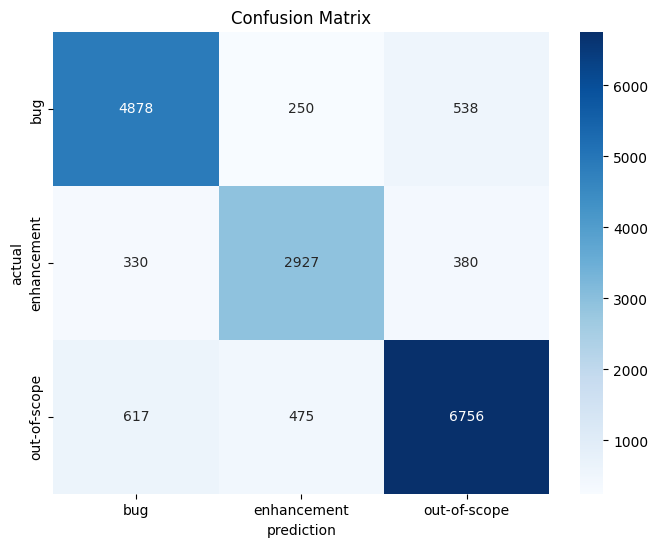

In [21]:
plt.figure(figsize = (8,6))
sns.heatmap(confusion_matrix,
            annot = True,
            fmt = 'd',
            cmap = 'Blues',
            xticklabels = label_names,
            yticklabels = label_names)
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Confusion Matrix')
plt.show()

Performance on nlbse'22 dataset

In [22]:
train_1 = pd.read_csv('data/train_nlbse22_msc_preprocessing_part1.csv')
train_2 = pd.read_csv('data/train_nlbse22_msc_preprocessing_part2.csv')
train_3 = pd.read_csv('data/train_nlbse22_msc_preprocessing_part3.csv')
train_4 = pd.read_csv('data/train_nlbse22_msc_preprocessing_part4.csv')

In [23]:
print(train_1.shape[0], train_2.shape[0], train_3.shape[0], train_4.shape[0])

174170 174170 174170 174169


In [24]:
print(train_1.shape[0] + train_2.shape[0] + train_3.shape[0]+ train_4.shape[0])

696679


In [25]:
test_n = pd.read_csv('data/test_nlbse22_msc_preprocessing.csv')

In [26]:
train_n = pd.concat([train_1, train_2, train_3, train_4], ignore_index = True)
train_n.reset_index(drop = True, inplace = True)

print('Number of issues: ', train_n.shape, test_n.shape)

Number of issues:  (696679, 2) (80518, 2)


In [27]:
nlbse_dataset = pd.concat([train_n, test_n], ignore_index = True)
nlbse_dataset.reset_index(drop = True, inplace = True)
nlbse_dataset.shape[0]

777197

In [28]:
hours, remainder = divmod((datetime.datetime.now() - start).total_seconds(), 3600)
minutes, seconds = divmod(remainder, 60)
print('-'*5,  name, ', duration is:', '%dh:%dm:%ds' % (hours, minutes, seconds), '-'*5, '\n\n')
results_n, model_outputs_n, wrong_pred_n = model.eval_model(nlbse_dataset, verbose=True, **metrics_recom)
results_n

----- roberta , duration is: 0h:43m:46s ----- 




  0%|          | 0/777197 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7772 [00:00<?, ?it/s]

{'mcc': 0.5731121997994598,
 'accuracy': 0.7290648316964682,
 'p_micro': 0.7290648316964682,
 'p_macro': 0.6505889567935806,
 'p_w': 0.8049339878112532,
 'r_micro': 0.7290648316964682,
 'r_macro': 0.6923543148758718,
 'r_w': 0.7290648316964682,
 'f_micro': 0.7290648316964682,
 'f_macro': 0.6441688487129226,
 'f_w': 0.7567504540361252,
 'classificationReport': {'0.0': {'precision': 0.8875697018187615,
   'recall': 0.7462896233175073,
   'f1-score': 0.8108214070181483,
   'support': 387966},
  '1.0': {'precision': 0.8203563482070476,
   'recall': 0.7357746844920778,
   'f1-score': 0.7757668481505282,
   'support': 323209},
  '2.0': {'precision': 0.24384082035493262,
   'recall': 0.5949986368180303,
   'f1-score': 0.3459182909700911,
   'support': 66022},
  'accuracy': 0.7290648316964682,
  'macro avg': {'precision': 0.6505889567935806,
   'recall': 0.6923543148758718,
   'f1-score': 0.6441688487129226,
   'support': 777197},
  'weighted avg': {'precision': 0.8049339878112532,
   'recall'

In [29]:
model_outputs_n.shape[0]

777197

In [30]:
model_outputs_df_n = pd.DataFrame(model_outputs_n, columns = ['bug', 'enhancement', 'question'])
model_outputs_df_n.head()

,bug,enhancement,question
0,-1.599609,-2.417969,4.250000
1,-1.804688,0.327637,1.689453
2,-0.854492,0.184570,0.718262
3,-0.114319,3.275391,-3.455078
4,-1.008789,3.357422,-2.779297


In [31]:
def get_prediction_question(row):
  max_value = row.max()
  if max_value == row['bug']:
    return 0
  elif max_value == row['enhancement']:
    return 1
  elif max_value == row['question']:
    return 2

In [32]:
label_names = ['bug', 'enhancement', 'question']

In [33]:
model_outputs_df_n['prediction'] = model_outputs_df_n.apply(get_prediction_question, axis = 1)
model_outputs_df_n.head()

,bug,enhancement,question,prediction
0,-1.599609,-2.417969,4.250000,2
1,-1.804688,0.327637,1.689453,2
2,-0.854492,0.184570,0.718262,2
3,-0.114319,3.275391,-3.455078,1
4,-1.008789,3.357422,-2.779297,1


In [34]:
model_outputs_df_n['actual'] = nlbse_dataset['labels']

In [35]:
predicted_labels_n = model_outputs_df_n['prediction']
actual_labels_n = model_outputs_df_n['actual']

In [36]:
from sklearn.metrics import confusion_matrix

In [37]:
confusion_matrix_n = confusion_matrix(actual_labels_n, predicted_labels_n)
print(confusion_matrix_n)

[[289535  40865  57566]
 [ 21148 237809  64252]
 [ 15528  11211  39283]]


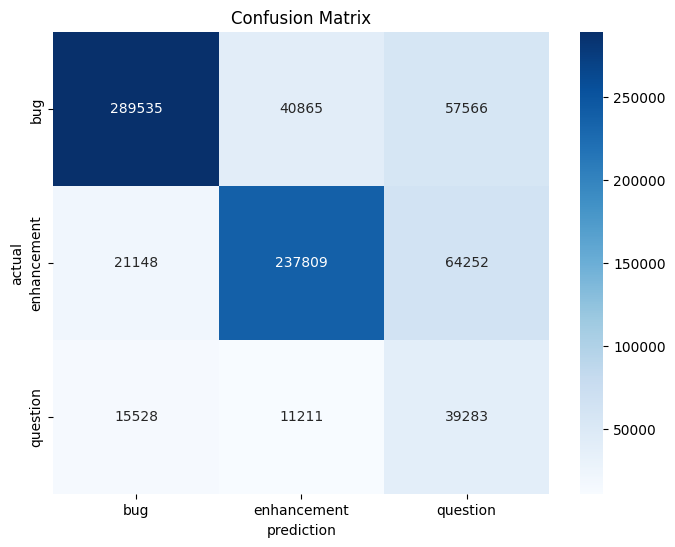

In [38]:
plt.figure(figsize = (8,6))
sns.heatmap(confusion_matrix_n,
            annot = True,
            fmt = 'd',
            cmap = 'Blues',
            xticklabels = label_names,
            yticklabels = label_names)
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Confusion Matrix')
plt.show()

Performance on MSc dataset - bug - enhancement - question

In [39]:
train_msc = pd.read_csv('data/train_bug_ench_question_msc_preprocessing.csv')
test_msc = pd.read_csv('data/test_bug_ench_question_msc_preprocessing.csv')
print('Number of issues: ', train_msc.shape, test_msc.shape)

Number of issues:  (94830, 2) (10537, 2)


In [40]:
msc_dataset = pd.concat([train_msc, test_msc], ignore_index = True)
msc_dataset.reset_index(drop = True, inplace = True)
msc_dataset.shape[0]

105367

In [41]:
hours, remainder = divmod((datetime.datetime.now() - start).total_seconds(), 3600)
minutes, seconds = divmod(remainder, 60)
print('-'*5,  name, ', duration is:', '%dh:%dm:%ds' % (hours, minutes, seconds), '-'*5, '\n\n')
results_msc, model_outputs_msc, wrong_pred_msc = model.eval_model(msc_dataset, verbose=True, **metrics_recom)
results_msc

----- roberta , duration is: 1h:5m:49s ----- 




  0%|          | 0/105367 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/1054 [00:00<?, ?it/s]

{'mcc': 0.8032057189388588,
 'accuracy': 0.8828665521463077,
 'p_micro': 0.8828665521463077,
 'p_macro': 0.8271201621717986,
 'p_w': 0.8956655010103337,
 'r_micro': 0.8828665521463077,
 'r_macro': 0.8654268174462075,
 'r_w': 0.8828665521463077,
 'f_micro': 0.8828665521463077,
 'f_macro': 0.8406706429636605,
 'f_w': 0.8869170107964599,
 'classificationReport': {'0.0': {'precision': 0.9307976660747291,
   'recall': 0.9065671273009653,
   'f1-score': 0.9185226246568974,
   'support': 56661},
  '1.0': {'precision': 0.9364333709936374,
   'recall': 0.8660122631911793,
   'f1-score': 0.8998471494078826,
   'support': 36369},
  '2.0': {'precision': 0.6141294494470296,
   'recall': 0.8237010618464781,
   'f1-score': 0.7036421548262014,
   'support': 12337},
  'accuracy': 0.8828665521463077,
  'macro avg': {'precision': 0.8271201621717986,
   'recall': 0.8654268174462075,
   'f1-score': 0.8406706429636605,
   'support': 105367},
  'weighted avg': {'precision': 0.8956655010103337,
   'recall': 0

In [42]:
model_outputs_msc.shape[0]

105367

In [43]:
model_outputs_df_msc = pd.DataFrame(model_outputs_msc, columns = ['bug', 'enhancement', 'question'])
model_outputs_df_msc.head()

,bug,enhancement,question
0,4.847656,-2.132812,-2.591797
1,4.875000,-2.482422,-2.332031
2,4.851562,-2.275391,-2.527344
3,4.859375,-2.425781,-2.361328
4,4.835938,-2.369141,-2.427734


In [44]:
model_outputs_df_msc['prediction'] = model_outputs_df_msc.apply(get_prediction_question, axis = 1)
model_outputs_df_msc.head()

,bug,enhancement,question,prediction
0,4.847656,-2.132812,-2.591797,0
1,4.875000,-2.482422,-2.332031,0
2,4.851562,-2.275391,-2.527344,0
3,4.859375,-2.425781,-2.361328,0
4,4.835938,-2.369141,-2.427734,0


In [45]:
model_outputs_df_msc['actual'] = msc_dataset['labels']

In [46]:
predicted_labels_msc = model_outputs_df_msc['prediction']
actual_labels_msc = model_outputs_df_msc['actual']

In [47]:
from sklearn.metrics import confusion_matrix

In [48]:
confusion_matrix_msc = confusion_matrix(actual_labels_msc, predicted_labels_msc)
print(confusion_matrix_msc)

[[51367  1442  3852]
 [ 2340 31496  2533]
 [ 1479   696 10162]]


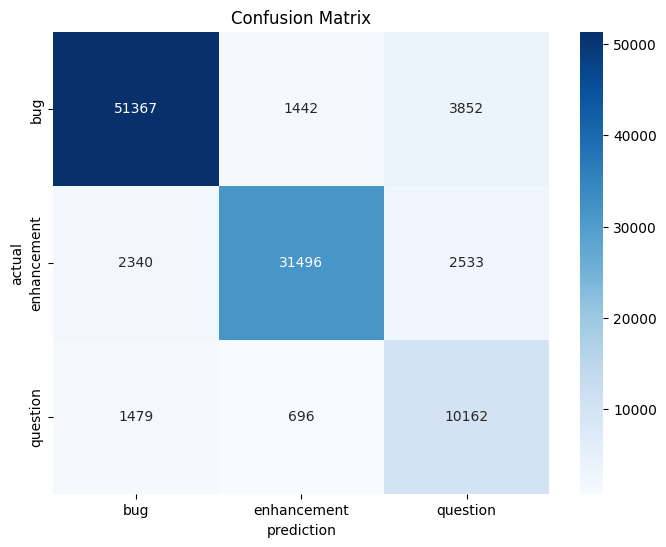

In [49]:
plt.figure(figsize = (8,6))
sns.heatmap(confusion_matrix_msc,
            annot = True,
            fmt = 'd',
            cmap = 'Blues',
            xticklabels = label_names,
            yticklabels = label_names)
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Confusion Matrix')
plt.show()